# Navigation

---

This notebook solves the Banana environment from the Unity ML-Agents for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Two agents are tested:
- Double Deep Q-Network (see Mnih et al., Human-level control through deep reinforcement learning, 2015),
- Prioritized Double Deep Q-Network (see Shuan et al., Prioritized experience replay, 2016).

Author: Piotr Zioło

### Load the environment

In [1]:
from unityagents import UnityEnvironment
import gym
import random
import torch
import numpy as np
from collections import deque
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Fix the dying kernel problem
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### The game

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions. The first 35 dimensions contain ray-based perception of objects around agent's forward direction. The before last variable contains the rotation speed of the agent and the last variable contains the forward/backward speed of the agent. 

There are 7 rays used, each encoded in 5 numbers. The rays go out of the agent at the following angles [20, 90, 160, 45, 135, 70, 110], where 90 degrees is the direction exactly ahead of the agent. The first four variables in the state vector describing  a given ray indicate if a given type of object from the list [Banana, Wall, BadBanana, Agent, Distance] (in that order) is present along the ray. The fifth variable gives the distance to the closest object along the ray. For instance [1, 1, 0, 0, 0.5] means that there is a yellow banana and a wall along the ray and that the banana is halfway along the ray length. (The exact logic of rays was figured out from the source code by iandanforth - https://github.com/Unity-Technologies/ml-agents/issues/1134)

A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [4]:
# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of agents in the environment
print('Number of agents:', len(env_info.agents))

# Number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# The state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Define the training function

In [5]:
# Define the training function

def train_agent(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    best_score = -np.inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = int(agent.act(state, eps))
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward   
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        mean_score = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score), end="")
#         if mean_score > best_score and mean_score > 0:
#             torch.save(agent.qnetwork_local.state_dict(), 'models/checkpoint{}_{}.pth'.format(i_episode, mean_score))
#             best_score = mean_score
        if i_episode % 100 == 0:
            torch.save(agent.qnetwork_local.state_dict(), 'models/checkpoint{}_{}.pth'.format(i_episode, mean_score))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        if mean_score >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            torch.save(agent.qnetwork_local.state_dict(), 'models/checkpoint.pth')
            break
    return scores

### Define and train the DDQN agent

In [27]:
%load_ext autoreload
%autoreload 2

from ddqn_agent import DDQNAgent

ddqn_agent = DDQNAgent(state_size=37, action_size=4, seed=0)

Running on cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
scores = train_agent(ddqn_agent)

data = pd.DataFrame(scores, columns=['Reward'])
data.loc[:, 'Episode'] = range(0, len(scores))
data.to_csv("models/ddqn_rewards.csv", index=False)

Episode 100	Average Score: 0.84
Episode 200	Average Score: 6.54
Episode 300	Average Score: 12.90
Episode 400	Average Score: 19.46
Episode 500	Average Score: 25.80
Episode 600	Average Score: 27.02
Episode 700	Average Score: 28.72
Episode 800	Average Score: 29.00
Episode 860	Average Score: 30.02
Environment solved in 860 episodes!	Average Score: 30.02


### Define and train the Prioritized DDQN agent

In [38]:
%load_ext autoreload
%autoreload 2

from prioritized_ddqn_agent import PrioritizedDDQNAgent

pddqn_agent = PrioritizedDDQNAgent(state_size=37, action_size=4, seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
scores = train_agent(pddqn_agent)

data = pd.DataFrame(scores, columns=['Reward'])
data.loc[:, 'Episode'] = range(0, len(scores))
data.to_csv("models/pddqn_rewards.csv", index=False)

Episode 100	Average Score: 1.12
Episode 200	Average Score: 8.70
Episode 300	Average Score: 14.22
Episode 400	Average Score: 20.22
Episode 500	Average Score: 25.90
Episode 600	Average Score: 27.96
Episode 700	Average Score: 28.32
Episode 739	Average Score: 30.12
Environment solved in 739 episodes!	Average Score: 30.12


### Plot the learning curves for all agents

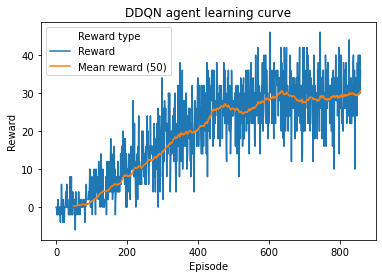

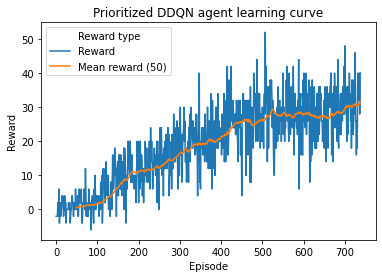

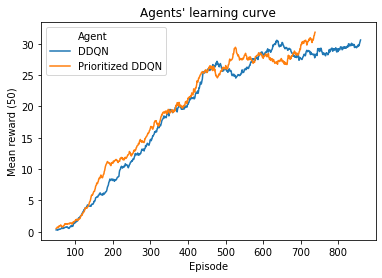

In [51]:
data = pd.read_csv("models/ddqn_rewards.csv")
data.loc[:, "Reward type"] = "Reward"
data_mean = data.copy()
data_mean.loc[:, "Reward"] = data_mean["Reward"].rolling(50).mean()
data_mean.loc[:, "Reward type"] = "Mean reward (50)"
data = pd.concat([data, data_mean])
sns_plot = sns.lineplot(x='Episode', y='Reward', hue="Reward type", data=data).set_title("DDQN agent learning curve")
sns_plot.figure.savefig("models/ddqn_scores.png")
plt.show()

data = pd.read_csv("models/pddqn_rewards.csv")
data.loc[:, "Reward type"] = "Reward"
data_mean = data.copy()
data_mean.loc[:, "Reward"] = data_mean["Reward"].rolling(50).mean()
data_mean.loc[:, "Reward type"] = "Mean reward (50)"
data = pd.concat([data, data_mean])
sns_plot = sns.lineplot(x='Episode', y='Reward', hue="Reward type", data=data).set_title("Prioritized DDQN agent learning curve")
sns_plot.figure.savefig("models/pddqn_scores.png")
plt.show()

data_ddqn = pd.read_csv("models/ddqn_rewards.csv")
data_ddqn.loc[:, "Agent"] = "DDQN"
data_ddqn.loc[:, "Mean reward (50)"] = data_ddqn["Reward"].rolling(50).mean()
data_pddqn = pd.read_csv("models/pddqn_rewards.csv")
data_pddqn.loc[:, "Agent"] = "Prioritized DDQN"
data_pddqn.loc[:, "Mean reward (50)"] = data_pddqn["Reward"].rolling(50).mean()

data = pd.concat([data_ddqn, data_pddqn])

sns_plot = sns.lineplot(x='Episode', y='Mean reward (50)', hue="Agent", data=data).set_title("Agents' learning curve")
sns_plot.figure.savefig("models/scores.png")
plt.show()

### Test the agent

In [55]:
# load the weights from file
ddqn_agent.qnetwork_local.load_state_dict(torch.load('models/checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = int(ddqn_agent.act(state, 0))              # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 6.0


In [56]:
env.close()